# Predicting Red Wine Quality
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

## Citations
<pre>
Dua, D. and Karra Taniskidou, E. (2017). 
UCI Machine Learning Repository [http://archive.ics.uci.edu/ml/index.php]. 
Irvine, CA: University of California, School of Information and Computer Science.
</pre>

<pre>
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.
</pre>

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## EDA

In [2]:
red_wine = pd.read_csv('data/winequality-red.csv')
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<AxesSubplot:title={'center':'Red Wine Quality Scores'}, xlabel='count of wines', ylabel='quality score'>

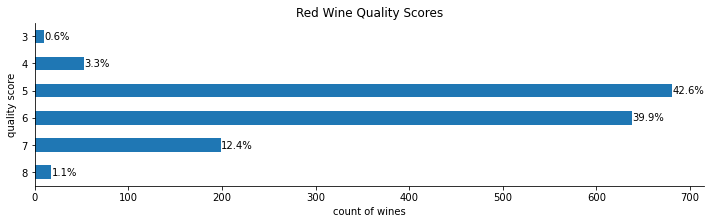

In [3]:
def plot_quality_scores(df, kind):
    ax = df.quality.value_counts().sort_index().plot.barh(
        title=f'{kind.title()} Wine Quality Scores', figsize=(12, 3)
    )
    ax.axes.invert_yaxis()
    for bar in ax.patches:
        ax.text(
            bar.get_width(), 
            bar.get_y() + bar.get_height()/2, 
            f'{bar.get_width()/df.shape[0]:.1%}',
            verticalalignment='center'
        )
    plt.xlabel('count of wines')
    plt.ylabel('quality score')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    return ax

plot_quality_scores(red_wine, 'red')

In [4]:
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
red_wine['high_quality'] = pd.cut(red_wine.quality, bins=[0, 6, 10], labels=[0, 1])
red_wine.high_quality.value_counts(normalize=True)

0    0.86429
1    0.13571
Name: high_quality, dtype: float64

It's important to perform an in-depth exploration of the data before modeling. This includes consulting domain experts, looking for correlations between variables, examining distributions, etc. The visualizations covered in chapters 5 and 6 will prove indispensible for this process. One such visualization is the pairplot. In order to predict high quality red wines, we would try to see if there is a difference in the distribution of our variables for low versus high quality red wines. We would also look for correlations. Some other helpful plot types include box plots, heatmaps, and the scatter matrix. 

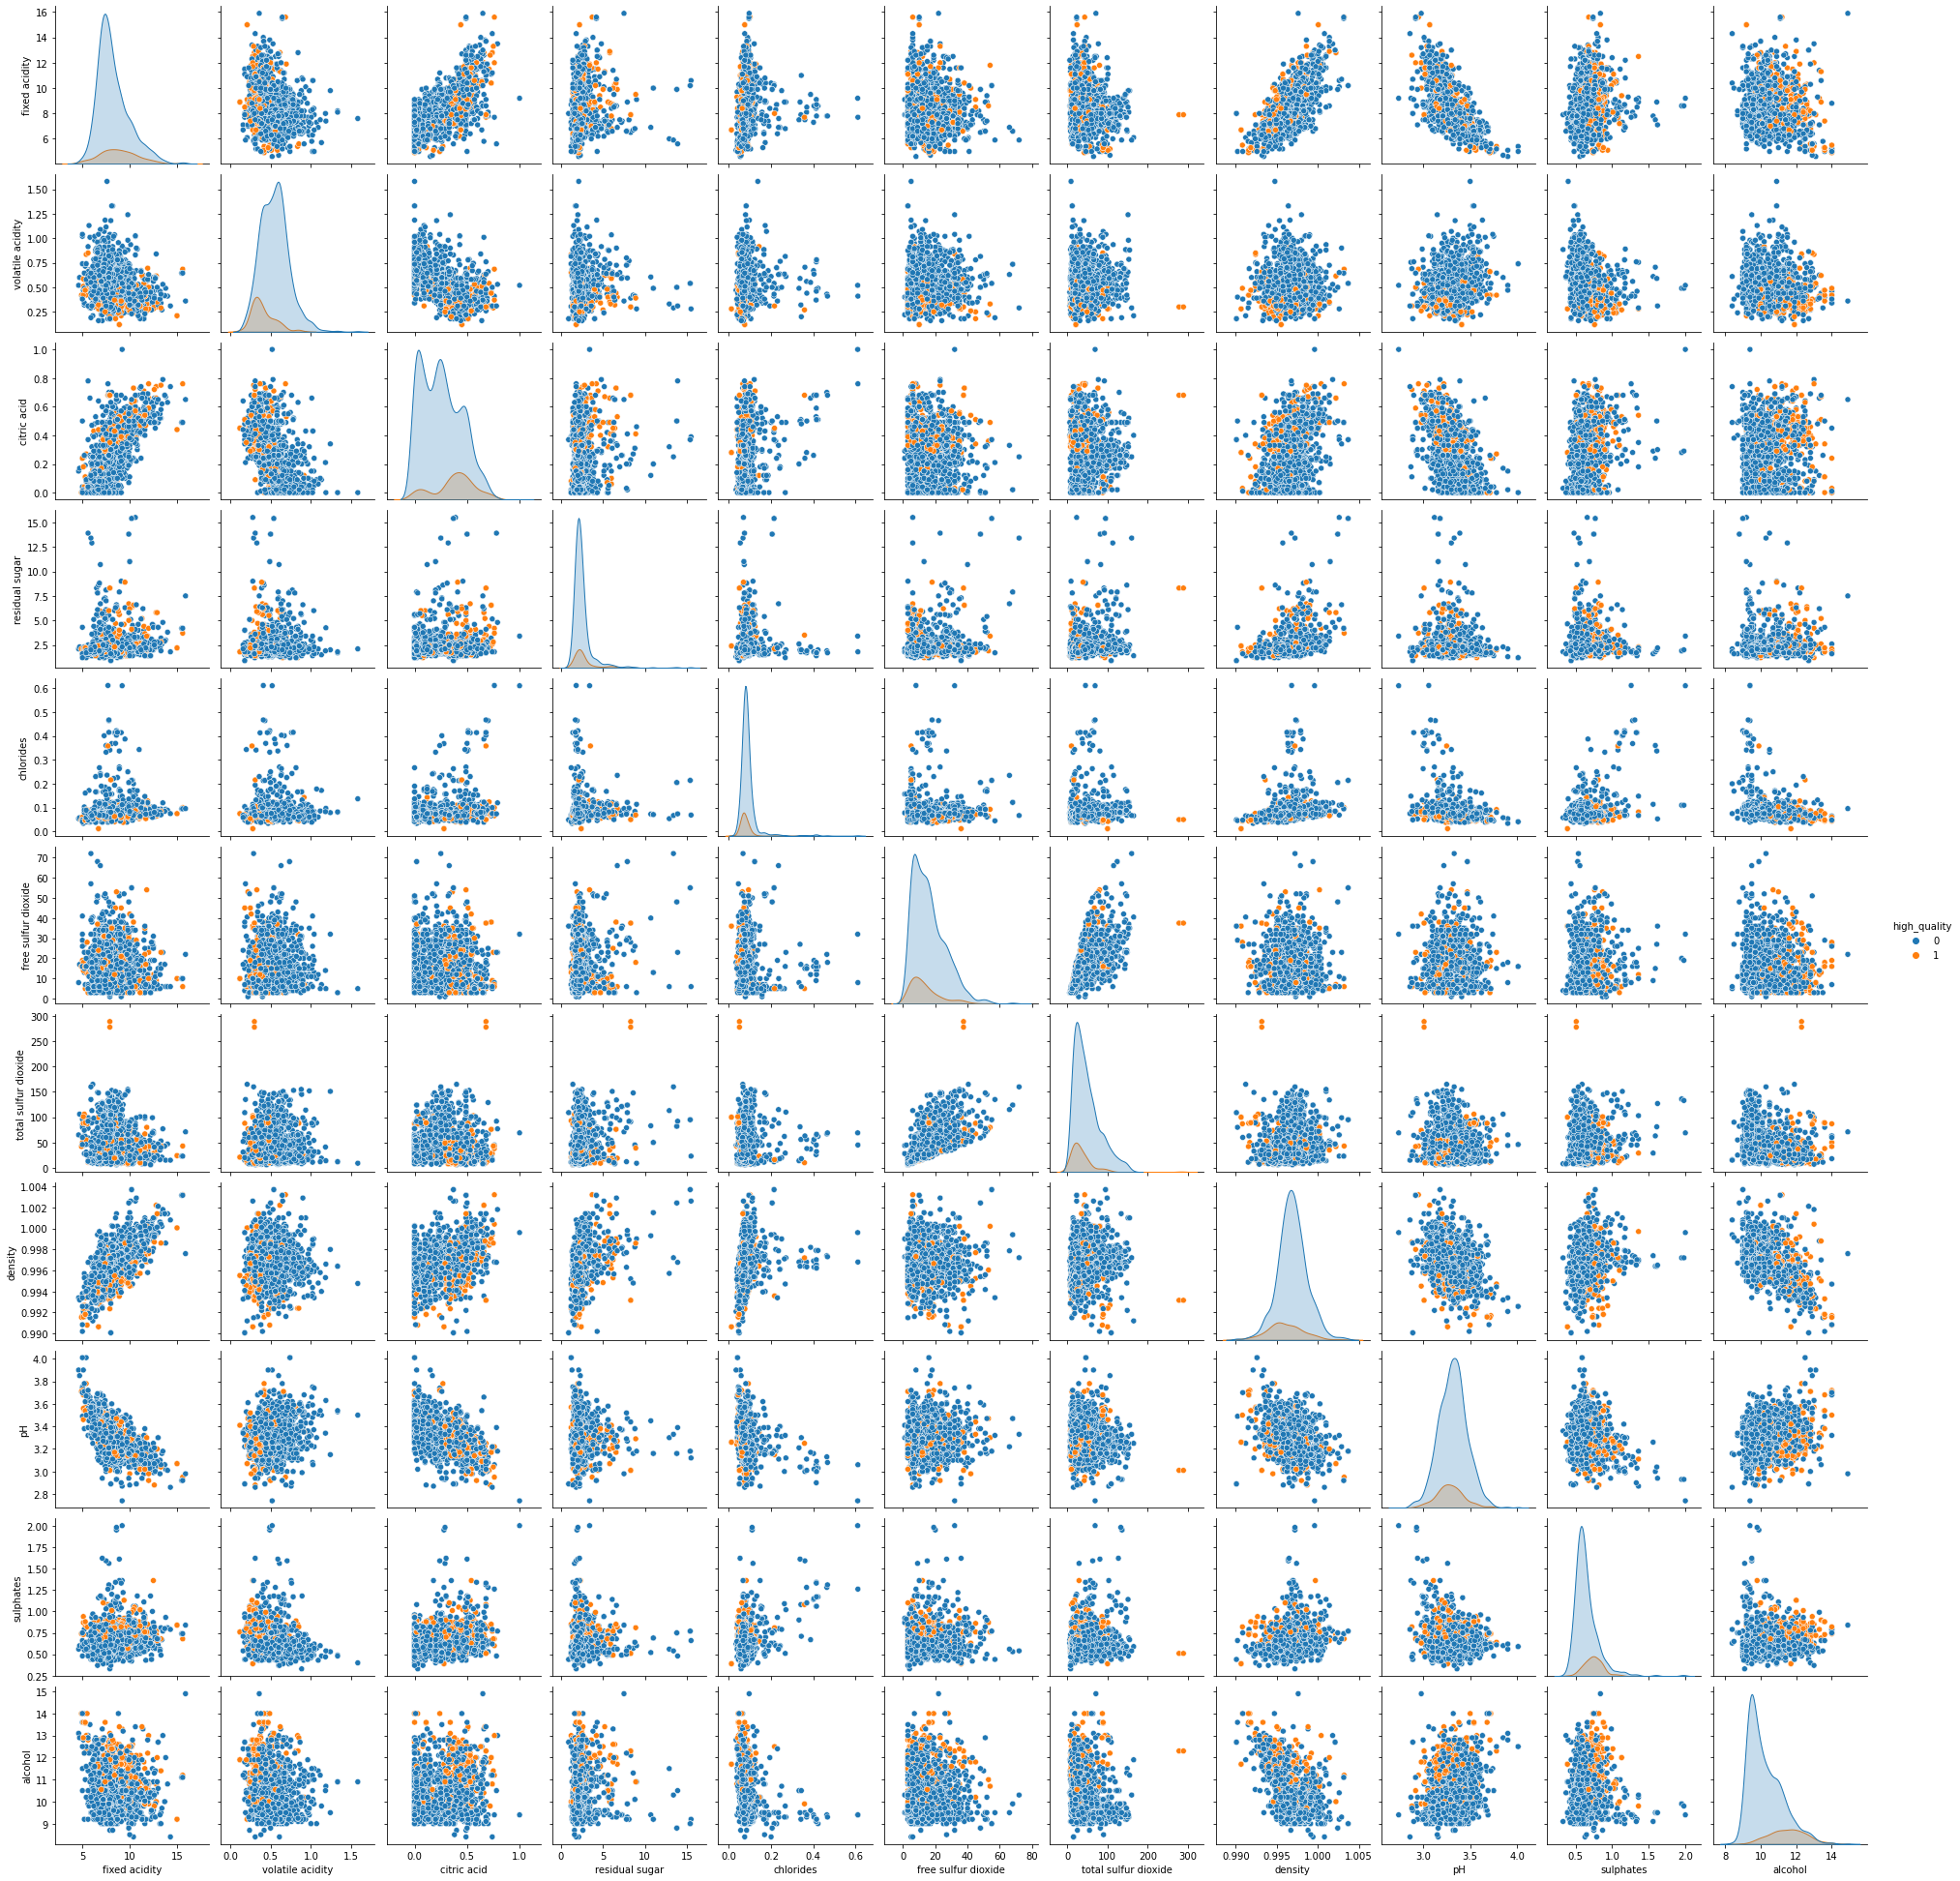

In [7]:
sns.pairplot(red_wine.drop(columns='quality'), hue='high_quality')

## Logistic Regression
The logistic sigmoid function gives values in the range [0, 1], which can be used as probabilities for classification problems:

In [8]:
from visual_aids import ml_viz
ml_viz.logistic_sigmoid()

ModuleNotFoundError: No module named 'visual_aids'

### Building a model
1. separate x and y data
2. get the training and testing sets
3. build a pipeline with preprocessing (standardizing here) ending in the model (logistic regression here)
4. fit the model
5. make predictions
6. evaluate predictions

Steps 1 and 2:

In [9]:
from sklearn.model_selection import train_test_split

# 1
red_y = red_wine.pop('high_quality')
red_X = red_wine.drop(columns='quality')

# 2
r_X_train, r_X_test, r_y_train, r_y_test = train_test_split(
    red_X, red_y, test_size=0.1, random_state=0, stratify=red_y
)

Since we stratified on the high quality versus not from the entire dataset (from `red_y`), we preserve the ratio of high quality to not in both our test and training sets:

In [ ]:
red_y.value_counts(normalize=True)

Percentage of high- and low-quality red wines in the training set:

In [ ]:
r_y_train.value_counts(normalize=True)

Percentage of high- and low-quality red wines in the test set:

In [ ]:
r_y_test.value_counts(normalize=True)

Step 3:

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

red_quality_lr = Pipeline([
    ('scale', StandardScaler()), 
    ('lr', LogisticRegression(
        class_weight='balanced', random_state=0
    ))
])

Step 4:

In [ ]:
red_quality_lr.fit(r_X_train, r_y_train)

Step 5:

In [ ]:
quality_preds = red_quality_lr.predict(r_X_test)

### Evaluation

Step 6

We can use a confusion matrix to see how the model's predictions align with the actual class labels. This model gets 36 wrong. It seems to predict high quality too often:

In [ ]:
from ml_utils.classification import confusion_matrix_visual

confusion_matrix_visual(r_y_test, quality_preds, ['low', 'high'])

Accuracy tells us how many the model got right. However, it is often misleading in cases of class imbalance (like here):

In [ ]:
# mean accuracy
red_quality_lr.score(r_X_test, r_y_test)

Zero-one loss is our error rate:

In [ ]:
from sklearn.metrics import zero_one_loss
zero_one_loss(r_y_test, quality_preds)

Another way to look at performance is with the classification report. Performance is better on the low-quality wines (0 in output below) that are the majority:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(r_y_test, quality_preds))

Precision, recall, and $F_1$ score are more informative when dealing with class imbalance. They ignore true negatives which are likely to be very high (when predicting the minority class):

In [ ]:
ml_viz.portion_of_confusion_matrix_considered({'precision', 'recall'})

The ROC curve indicates this is better than the random guessing baseline; however, the performance isn't great:

In [ ]:
from ml_utils.classification import plot_roc

plot_roc(r_y_test, red_quality_lr.predict_proba(r_X_test)[:,1])

Remember, the ROC curve includes true negatives so it is optimistic in cases of class imbalance. When faced with class imbalance, we use precision-recall curves since ROC curves will be optimistic of model performance. AP is the weighted average precision, and AUC is the area under the curve once again in the range [0, 1]. The baseline is now the percentage of observations belonging to the positive class. Values below this line are worse than random:

In [ ]:
from ml_utils.classification import plot_pr_curve

plot_pr_curve(r_y_test, red_quality_lr.predict_proba(r_X_test)[:,1])

<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
        <a href="../../ch_08/anomaly_detection.ipynb">
            <button>&#8592; Chapter 8</button>
        </a>
        <a href="./preprocessing.ipynb">
            <button>Preprocessing</button>
        </a>
        <a href="./planets_ml.ipynb">
            <button>Planets</button>
        </a>
        <a href="./wine.ipynb">
            <button>Red + White Wine</button>
        </a>
    </div>
    <div style="float: right;">
        <a href="../../solutions/ch_09/exercise_1.ipynb">
            <button>Solutions</button>
        </a>
        <a href="../ch_10/red_wine.ipynb">
            <button>Chapter 10 &#8594;</button>
        </a>
    </div>
</div>
<hr>